Using Athena version 20.7.3.8, on /afs/cern.ch/user/m/mazhang/eos/atlas/user/m/mazhang/Data/xAOD/VertexingXAODttbar/XAOD.pileupTruth.ttbar.pool.root.

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
datafile = "Data/TrackAssociation/20160421.txt"
data = np.loadtxt(datafile, delimiter="\t", skiprows=1) #first row is branch names

In [59]:
branch_names = open(datafile).readline().rstrip().split(",")
branch_names = [c.strip() for c in branch_names]

In [60]:
y = np.array([row[branch_names.index("correctVtx")] for row in data])
X = np.delete(data, branch_names.index("correctVtx"), 1)
branch_names.pop(branch_names.index("correctVtx"));
X = np.delete(X, branch_names.index("truVtxX"), 1)
branch_names.pop(branch_names.index("truVtxX"));
X = np.delete(X, branch_names.index("truVtxY"), 1)
branch_names.pop(branch_names.index("truVtxY"));
X = np.delete(X, branch_names.index("truVtxZ"), 1)
branch_names.pop(branch_names.index("truVtxZ"));

In [62]:
from sklearn.cross_validation import train_test_split

#X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=492)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=492)

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=0.01*len(X_train))
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=377.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [64]:
y_predicted = bdt.predict(X_test)
print (classification_report(y_test, y_predicted, target_names=["false trk/vtx match", "true trk/vtx match"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

                     precision    recall  f1-score   support

false trk/vtx match       0.81      0.40      0.53      3272
 true trk/vtx match       0.88      0.98      0.93     15303

        avg / total       0.87      0.88      0.86     18575

Area under ROC curve: 0.8795


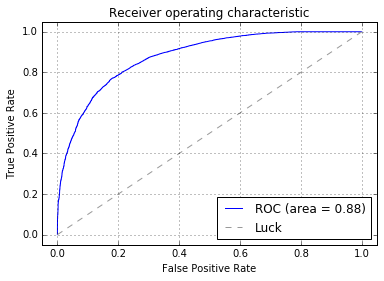

In [65]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

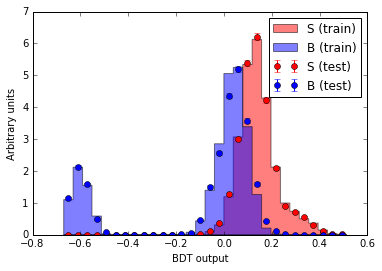

In [66]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='S (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='B (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)